In [25]:
import numpy as np
import os
from sklearn.model_selection import train_test_split

def load_data(data_folder, test_size=0.2, random_state=42):
    """
    加载 `feature_matrix.npy` 和 `labels.npy` 数据，并划分训练集和测试集。

    参数：
    - data_folder: 存放数据的文件夹路径
    - test_size: 测试集比例 (默认 20%)
    - random_state: 随机种子，保证可复现性

    返回：
    - X_train: 训练集特征，形状 (train_batches, num_windows, 15, num_channels)
    - X_test: 测试集特征，形状 (test_batches, num_windows, 15, num_channels)
    - y_train: 训练集标签，形状 (train_batches,)
    - y_test: 测试集标签，形状 (test_batches,)
    """
    # **加载数据**
    feature_path = os.path.join(data_folder, "feature_matrix.npy")
    label_path = os.path.join(data_folder, "labels.npy")

    if not os.path.exists(feature_path) or not os.path.exists(label_path):
        raise FileNotFoundError("特征文件或标签文件未找到，请检查路径！")

    X = np.load(feature_path)  # 形状 (num_batches, num_windows, 15, num_channels)
    y = np.load(label_path)  # 形状 (num_batches,)

    # **数据基本信息**
    print(f"Loaded features from {feature_path}, shape: {X.shape}")
    print(f"Loaded labels from {label_path}, shape: {y.shape}")

    # **划分训练集和测试集**
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=random_state
        )

    # **打印数据划分信息**
    print(f"Training set: X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"Testing set: X_test: {X_test.shape}, y_test: {y_test.shape}")

    return X_train, X_test, y_train, y_test

# **使用示例**
data_folder = r"E:\MSC\Spring\AML\GestureLink\data\G\windowed_data"
X_train, X_test, y_train, y_test = load_data(data_folder)



Loaded features from E:\MSC\Spring\AML\GestureLink\data\G\windowed_data\feature_matrix.npy, shape: (150, 59, 15, 7)
Loaded labels from E:\MSC\Spring\AML\GestureLink\data\G\windowed_data\labels.npy, shape: (150,)
[15  6  2 22  4 12  3 10 19  8 20  1  3 10 13 18  8 16 24 17 15 22  7  6
 11  5 26 13 20 25 18  9 21 24  3 17 10 22 11  2 11 21 22  1 17 15 19 24
 14 26 24 26 20 17  2  7 13 18 14 23  7  2 22  1 11 10 23 16 24  9 12  6
  2 10 17  7 25 19 21  9 19 22  4 25  1  5 11 20  9 10  5 25 12 13 20 11
 23 19  3  7 11  8 21  6 25  3  9 13 22  7  5 20 26 22 14  8  6 16 13 24
 19 21  8 13 12  7  5 25 16 26 23 14 16  3  9 21  7 15  4 12  6  7 13 14
 15 23  3 12 19  2]
Training set: X_train: (120, 59, 15, 7), y_train: (120,)
Testing set: X_test: (30, 59, 15, 7), y_test: (30,)


In [24]:
y_train

array([ 7, 18, 10,  1, 22,  3, 26, 13,  4, 21, 13,  5, 11,  8, 20, 22,  3,
       15,  7,  7, 23,  3, 23, 15,  8, 16, 20, 11, 17,  7, 13, 11,  5,  6,
       20,  2, 11, 16, 24, 19, 22, 24,  4,  8, 22,  1, 19, 17, 12, 13, 20,
       26, 17, 19, 19,  3, 14, 10,  1, 12,  3, 19, 25,  9, 21, 10, 19, 10,
       24,  7, 22, 16, 11,  2,  7,  3, 26, 11,  2,  1,  2,  5, 24,  8, 19,
       12,  2, 12,  9, 23, 25, 21, 14,  5, 14,  9, 13, 12, 22, 18, 15, 26,
       22,  6,  6, 20, 23,  6,  7,  6, 20, 17, 21,  2, 15,  6,  9, 13, 12,
       21])

In [21]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# **加载数据**
data_folder = r"E:\MSC\Spring\AML\GestureLink\data\G\windowed_data"
X_train, X_test, y_train, y_test = load_data(data_folder)
X_train = np.nan_to_num(X_train, nan=0.0)
X_test = np.nan_to_num(X_test, nan=0.0)
y_train = np.nan_to_num(y_train, nan = 0.0)
y_test = np.nan_to_num(y_test, nan = 0.0)
# **获取数据形状**
num_batches = X_train.shape[0]  # batch 维度
num_windows = X_train.shape[1]  # 时间步（窗口数 59）
num_features = X_train.shape[2]  # 特征数（15）
num_channels = X_train.shape[3]  # 通道数（1）

# **检测类别数量**
unique_classes = np.unique(y_train)
num_classes = len(unique_classes)  # 确保类别数正确

print(f"Corrected Classes: {num_classes}, Batches: {num_batches}, Windows: {num_windows}, Features: {num_features}, Channels: {num_channels}")

# **保持 X 形状**
X_train = X_train.reshape(num_batches, num_windows, num_features, num_channels)
X_test = X_test.reshape(X_test.shape[0], num_windows, num_features, num_channels)
X_train = X_train[:,:,:4,:1]
X_test = X_test[:,:,:4,:1]



# print(X_train.shape)

num_features = X_train.shape[2] 
num_channels = X_train.shape[3]
# **标签编码**
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)  # 转换成 0,1,2
y_test = encoder.transform(y_test)

# **转换为 One-Hot**
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")  # (batch, 59, 15, 1) (batch, 3)
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")  # (batch, 59, 15, 1) (batch, 3)

# print(num_features)
# **构建 LSTM 处理通道的模型**
model = Sequential([
    TimeDistributed(Conv1D(filters=16, kernel_size=3, activation='relu'), input_shape=(num_windows, num_features, num_channels)),  # 1D CNN 提取局部特征
    TimeDistributed(Flatten()),  # 压缩通道
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')  # 多分类
])

# **编译模型**
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# **训练模型**
epochs = 200
batch_size = 8

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

# **测试模型**
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# **计算准确率**
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f"Test Accuracy: {accuracy:.4f}")

# **保存模型**
# model.save("rnn_emg_model.h5")
# print("Model saved as rnn_emg_model.h5")


Loaded features from E:\MSC\Spring\AML\GestureLink\data\G\windowed_data\feature_matrix.npy, shape: (150, 59, 15, 7)
Loaded labels from E:\MSC\Spring\AML\GestureLink\data\G\windowed_data\labels.npy, shape: (150,)
Training set: X_train: (120, 59, 15, 7), y_train: (120,)
Testing set: X_test: (30, 59, 15, 7), y_test: (30,)
Corrected Classes: 26, Batches: 120, Windows: 59, Features: 15, Channels: 7
X_train shape: (120, 59, 4, 1), y_train shape: (120, 26)
X_test shape: (30, 59, 4, 1), y_test shape: (30, 26)
Epoch 1/200
15/15 [==============================] - 13s 212ms/step - loss: 3.2611 - accuracy: 0.0167 - val_loss: 3.2584 - val_accuracy: 0.0333
Epoch 2/200
15/15 [==============================] - 1s 64ms/step - loss: 3.2529 - accuracy: 0.0500 - val_loss: 3.2611 - val_accuracy: 0.0333
Epoch 3/200
15/15 [==============================] - 1s 74ms/step - loss: 3.2577 - accuracy: 0.0333 - val_loss: 3.2632 - val_accuracy: 0.0333
Epoch 4/200
15/15 [==============================] - 1s 69ms/step

KeyboardInterrupt: 

In [4]:
# **训练模型**
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 200
batch_size = 8

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

# **测试模型**
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# **计算准确率**
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/200
39/39 [==============================] - 7s 59ms/step - loss: 2.9775 - accuracy: 0.1122 - val_loss: 4.0560 - val_accuracy: 0.0385
Epoch 2/200
39/39 [==============================] - 1s 33ms/step - loss: 3.0157 - accuracy: 0.0962 - val_loss: 3.8993 - val_accuracy: 0.0256
Epoch 3/200
39/39 [==============================] - 1s 31ms/step - loss: 2.9761 - accuracy: 0.1058 - val_loss: 3.9837 - val_accuracy: 0.0385
Epoch 4/200
39/39 [==============================] - 1s 35ms/step - loss: 2.9929 - accuracy: 0.0897 - val_loss: 3.9803 - val_accuracy: 0.0256
Epoch 5/200
39/39 [==============================] - 1s 34ms/step - loss: 3.0069 - accuracy: 0.0577 - val_loss: 3.9710 - val_accuracy: 0.0256
Epoch 6/200
39/39 [==============================] - 1s 34ms/step - loss: 3.0061 - accuracy: 0.0801 - val_loss: 3.9995 - val_accuracy: 0.0256
Epoch 7/200
39/39 [==============================] - 1s 38ms/step - loss: 2.9735 - accuracy: 0.0673 - val_loss: 4.0288 - val_accuracy: 0.0385
Epoch 

KeyboardInterrupt: 

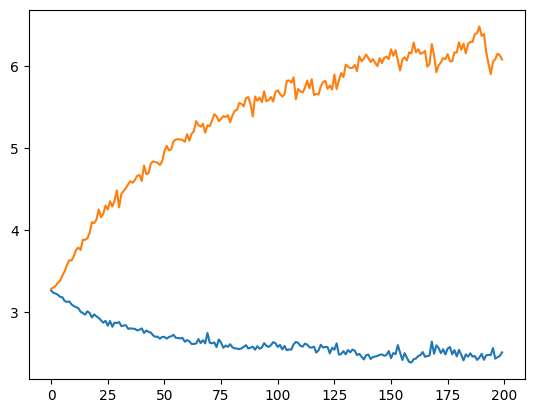

In [18]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

In [7]:
y_test


array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

In [20]:
X_train.shape

(36, 59, 15, 1)